# Student Performance Clustering Analysis

This notebook performs a comprehensive analysis of student learning behavior using K-Means clustering. We'll segment students based on their performance patterns, question difficulty handling, and topic diversity.

## Objectives:
1. **Data Loading & Cleaning**: Import and prepare the dataset
2. **Feature Engineering**: Create meaningful student behavior features
3. **Anomaly Detection**: Identify and remove outlier profiles
4. **K-Means Clustering**: Segment students into behavioral groups
5. **Visualization & Insights**: Analyze cluster characteristics

---

## 1. Import Required Libraries

We'll import libraries for data manipulation, visualization, machine learning, and clustering.

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

---

## 2. Data Loading & Initial Exploration

Load the student performance dataset and explore its structure.

In [129]:
# Load the dataset
df = pd.read_csv("./data/data.csv", encoding="latin-1", sep=";")

# Rename columns for better readability
column_mapping = {
    "Student ID": "student_id",
    "Student Country": "country",
    "Question ID": "question_id",
    "Type of Answer": "is_correct",
    "Question Level": "q_level",
    "Topic": "topic",
    "Subtopic": "subtopic",
    "Keywords": "keywords",
}
df = df.rename(columns=column_mapping)

print(f"Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset loaded successfully: 9546 rows, 8 columns


,student_id,country,question_id,is_correct,q_level,topic,subtopic,keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."


### 2.1 Dataset Overview

In [130]:
# Display column names
print("Column Names:")
print(df.columns.tolist())

Column Names:
['student_id', 'country', 'question_id', 'is_correct', 'q_level', 'topic', 'subtopic', 'keywords']


In [131]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9546 entries, 0 to 9545
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   student_id   9546 non-null   int64 
 1   country      9546 non-null   object
 2   question_id  9546 non-null   int64 
 3   is_correct   9546 non-null   int64 
 4   q_level      9546 non-null   object
 5   topic        9546 non-null   object
 6   subtopic     9546 non-null   object
 7   keywords     9546 non-null   object
dtypes: int64(3), object(5)
memory usage: 596.8+ KB


In [132]:
# Statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
student_id,9546.0,775.402263,460.590559,26.0,380.0,885.0,1219.0,1565.0
question_id,9546.0,478.912319,249.244061,77.0,323.0,428.0,571.0,1549.0
is_correct,9546.0,0.468259,0.499018,0.0,0.0,0.0,1.0,1.0


In [133]:
# Check unique values in each column
print("Number of unique values per column:\n")
for col in df.columns:
    print(f"{col:20s}: {len(df[col].unique()):,}")

Number of unique values per column:

student_id          : 372
country             : 8
question_id         : 833
is_correct          : 2
q_level             : 2
topic               : 14
subtopic            : 24
keywords            : 365


---

## 3. Data Cleaning & Preprocessing

Handle duplicates and prepare the data for analysis.

### 3.1 Handling Duplicate Data

In [134]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count:,}")
print(f"Percentage of duplicates: {(duplicate_count/len(df)*100):.2f}%")

Number of duplicate rows: 2,083
Percentage of duplicates: 21.82%


In [135]:
# Remove duplicate rows
original_shape = df.shape[0]
df.drop_duplicates(inplace=True)
removed = original_shape - df.shape[0]

print(f"Removed {removed:,} duplicate rows")
print(f"Clean dataset: {df.shape[0]:,} interactions remaining")

Removed 2,083 duplicate rows
Clean dataset: 7,463 interactions remaining


---

## 4. Feature Engineering

Create student-level features by aggregating interaction data. We'll build features that capture:
- **Overall Performance**: Average accuracy and total questions attempted
- **Difficulty Handling**: Performance across different question levels
- **Topic Diversity**: Number of unique topics explored

### 4.1 Basic Student Metrics

In [136]:
# Aggregate basic metrics per student
final_df = (
    df.groupby("student_id")
    .agg({"is_correct": "mean", "question_id": "count"})
    .rename(columns={"is_correct": "Avg_Accuracy", "question_id": "Total_Questions"})
)

print(f"Created student profiles: {final_df.shape[0]:,} students")
print(f"\nBasic Metrics Summary:")
print(final_df.describe())
final_df.head()

Created student profiles: 372 students

Basic Metrics Summary:
       Avg_Accuracy  Total_Questions
count    372.000000       372.000000
mean       0.453579        20.061828
std        0.268556        23.117628
min        0.000000         1.000000
25%        0.250000         7.000000
50%        0.451411        13.000000
75%        0.631313        27.000000
max        1.000000       199.000000


,Avg_Accuracy,Total_Questions
student_id,,
26,0.724638,69
28,0.510204,49
36,0.514286,35
37,0.593750,128
41,0.568966,58


### 4.2 Advanced Features: Difficulty & Diversity

In [137]:
# Configuration parameters
MIN_ATTEMPTS = 5
CONTAMINATION_RATE = 0.03
K_CHOICE = 4
RANDOM_STATE = 42

# Feature 1: Accuracy by difficulty level
difficulty_stats = df.pivot_table(
    index="student_id", 
    columns="q_level", 
    values="is_correct", 
    aggfunc="mean"
).fillna(0)
difficulty_stats.columns = ["Acc_" + str(c) for c in difficulty_stats.columns]

# Feature 2: Topic diversity (number of unique topics)
topic_stats = df.groupby("student_id")["topic"].nunique()
topic_stats.name = "Topic_Diversity"

# Combine all features
X = final_df.join(difficulty_stats).join(topic_stats).fillna(0)

# Filter: Keep only students with minimum attempts
X = X[X["Total_Questions"] >= MIN_ATTEMPTS]
FEATURE_COLS = X.columns.tolist()

print(f"✓ Feature Engineering Complete")
print(f"  - Total features: {len(FEATURE_COLS)}")
print(f"  - Student profiles: {X.shape[0]:,}")
print(f"  - Min questions threshold: {MIN_ATTEMPTS}")
print(f"\nFeatures created: {FEATURE_COLS}")

✓ Feature Engineering Complete
  - Total features: 5
  - Student profiles: 316
  - Min questions threshold: 5

Features created: ['Avg_Accuracy', 'Total_Questions', 'Acc_Advanced', 'Acc_Basic', 'Topic_Diversity']


### 4.3 Feature Scaling

Standardize features to have mean=0 and std=1 for better model performance.

In [138]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[FEATURE_COLS])
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURE_COLS, index=X.index)

print("✓ Features scaled successfully")
print(f"  Shape: {X_scaled_df.shape}")
print(f"  Mean: {X_scaled_df.mean().mean():.4f} (should be ~0)")
print(f"  Std: {X_scaled_df.std().mean():.4f} (should be ~1)")

✓ Features scaled successfully
  Shape: (316, 5)
  Mean: 0.0000 (should be ~0)
  Std: 1.0016 (should be ~1)


---

## 5. Anomaly Detection

Use Isolation Forest to identify and remove outlier student profiles that might skew clustering results.

In [139]:
# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(
    n_estimators=100, 
    contamination=CONTAMINATION_RATE, 
    random_state=RANDOM_STATE
)
anomaly_labels = iso_forest.fit_predict(X_scaled_df)

# Add anomaly labels to the dataset
X["Anomaly_Label"] = anomaly_labels

# Separate normal and anomalous profiles
df_normal = X[X["Anomaly_Label"] == 1].drop(columns=["Anomaly_Label"])
df_anomalies = X[X["Anomaly_Label"] == -1].drop(columns=["Anomaly_Label"])

print("✓ Anomaly Detection Complete")
print(f"  - Normal profiles: {df_normal.shape[0]:,} ({df_normal.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  - Anomalies removed: {df_anomalies.shape[0]:,} ({df_anomalies.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  - Contamination rate: {CONTAMINATION_RATE*100:.1f}%")

✓ Anomaly Detection Complete
  - Normal profiles: 306 (96.8%)
  - Anomalies removed: 10 (3.2%)
  - Contamination rate: 3.0%


### 5.1 Inspect Clean Data

In [140]:
# Display sample of clean data
df_normal.head(10)

,Avg_Accuracy,Total_Questions,Acc_Advanced,Acc_Basic,Topic_Diversity
student_id,,,,,
28,0.510204,49,0.000000,0.510204,5
36,0.514286,35,0.571429,0.500000,3
52,0.357143,14,0.000000,0.357143,2
57,0.437500,16,0.000000,0.437500,2
61,0.625000,16,0.000000,0.625000,2
67,0.500000,8,0.000000,0.500000,2
69,0.777778,27,0.000000,0.777778,2
72,0.105263,57,0.000000,0.181818,3
81,0.521739,69,0.363636,0.595745,4


---

## 6. K-Means Clustering

Apply K-Means clustering to segment students into behavioral groups.

### 6.1 Re-scale Clean Data & Apply PCA

In [141]:
# Re-scale the clean data
scaler_clean = StandardScaler()
X_clean_scaled = scaler_clean.fit_transform(df_normal[FEATURE_COLS])
X_clean_scaled_df = pd.DataFrame(
    X_clean_scaled, columns=FEATURE_COLS, index=df_normal.index
)

# Apply PCA for dimensionality reduction (visualization)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_clean_scaled_df)
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"], index=df_normal.index)

print("✓ Data scaled and PCA applied")
print(f"  - PC1 variance explained: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  - PC2 variance explained: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  - Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

✓ Data scaled and PCA applied
  - PC1 variance explained: 38.42%
  - PC2 variance explained: 27.50%
  - Total variance explained: 65.92%


### 6.2 Optimal K Selection

Use Elbow Method and Silhouette Score to determine the optimal number of clusters.

Computing inertia for K = 2 to 9...


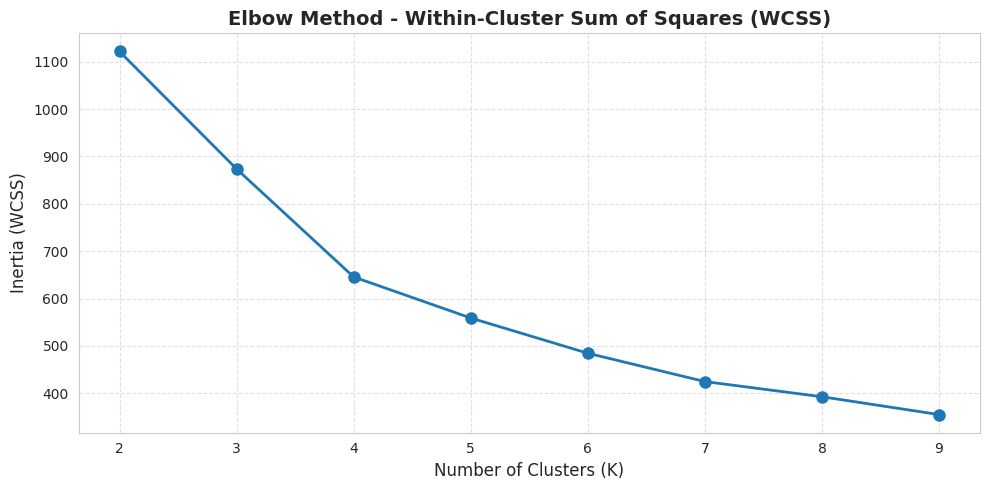

In [142]:
# Elbow Method: Calculate inertia for different K values
inertia_values = []
K_range = range(2, 10)

print("Computing inertia for K = 2 to 9...")
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans_temp.fit(X_clean_scaled_df)
    inertia_values.append(kmeans_temp.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia_values, marker="o", linewidth=2, markersize=8)
plt.title("Elbow Method - Within-Cluster Sum of Squares (WCSS)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Inertia (WCSS)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

Computing silhouette scores for K = 2 to 9...
  K=2: Silhouette Score = 0.2779
  K=3: Silhouette Score = 0.3108
  K=2: Silhouette Score = 0.2779
  K=3: Silhouette Score = 0.3108
  K=4: Silhouette Score = 0.3652
  K=5: Silhouette Score = 0.3786
  K=4: Silhouette Score = 0.3652
  K=5: Silhouette Score = 0.3786
  K=6: Silhouette Score = 0.3886
  K=7: Silhouette Score = 0.3420
  K=6: Silhouette Score = 0.3886
  K=7: Silhouette Score = 0.3420
  K=8: Silhouette Score = 0.3455
  K=9: Silhouette Score = 0.3402
  K=8: Silhouette Score = 0.3455
  K=9: Silhouette Score = 0.3402


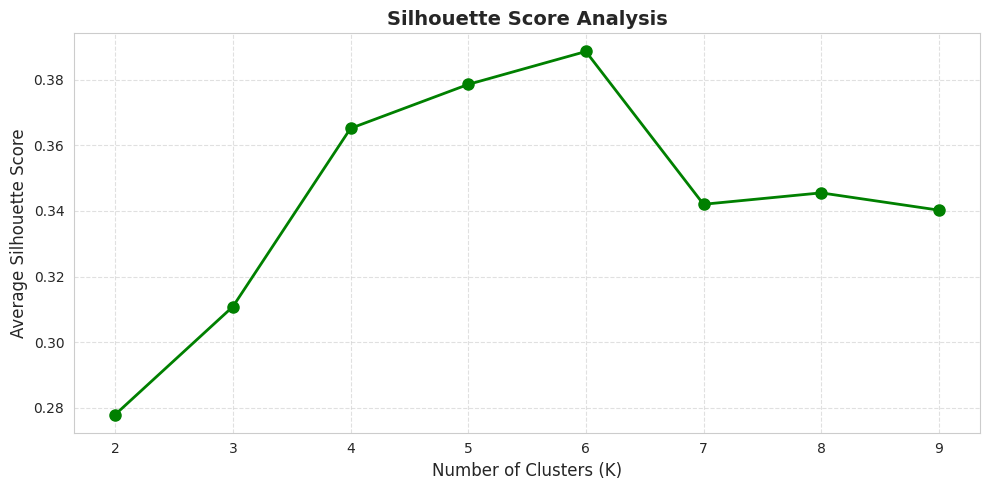


✓ Optimal K based on Silhouette Score: 6 (Score: 0.3886)


In [143]:
# Silhouette Score: Measure cluster quality
silhouette_scores = []
K_range = range(2, 10)

print("Computing silhouette scores for K = 2 to 9...")
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans_temp.fit_predict(X_clean_scaled_df)
    score = silhouette_score(X_clean_scaled_df, cluster_labels)
    silhouette_scores.append(score)
    print(f"  K={k}: Silhouette Score = {score:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker="o", linewidth=2, markersize=8, color='green')
plt.title("Silhouette Score Analysis", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Average Silhouette Score", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

# Identify optimal K
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✓ Optimal K based on Silhouette Score: {optimal_k} (Score: {max(silhouette_scores):.4f})")

### 6.3 Final Clustering with K=4

In [144]:
# Fit final K-Means model
kmeans_final = KMeans(n_clusters=K_CHOICE, random_state=RANDOM_STATE, n_init=10)
kmeans_final.fit(X_clean_scaled_df)

# Assign cluster labels
df_normal["Cluster"] = kmeans_final.labels_
pca_df["Cluster"] = kmeans_final.labels_
pca_df["Cluster"] = pca_df["Cluster"].astype("category")

# Display cluster distribution
print(f"✓ K-Means Clustering Complete (K={K_CHOICE})")
print(f"\nCluster Distribution:")
cluster_counts = df_normal["Cluster"].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} students ({count/len(df_normal)*100:.1f}%)")

✓ K-Means Clustering Complete (K=4)

Cluster Distribution:
  Cluster 0: 102 students (33.3%)
  Cluster 1: 71 students (23.2%)
  Cluster 2: 41 students (13.4%)
  Cluster 3: 92 students (30.1%)


---

## 7. Visualization & Cluster Analysis

Visualize the clusters and analyze their characteristics.

### 7.1 PCA Visualization of Clusters

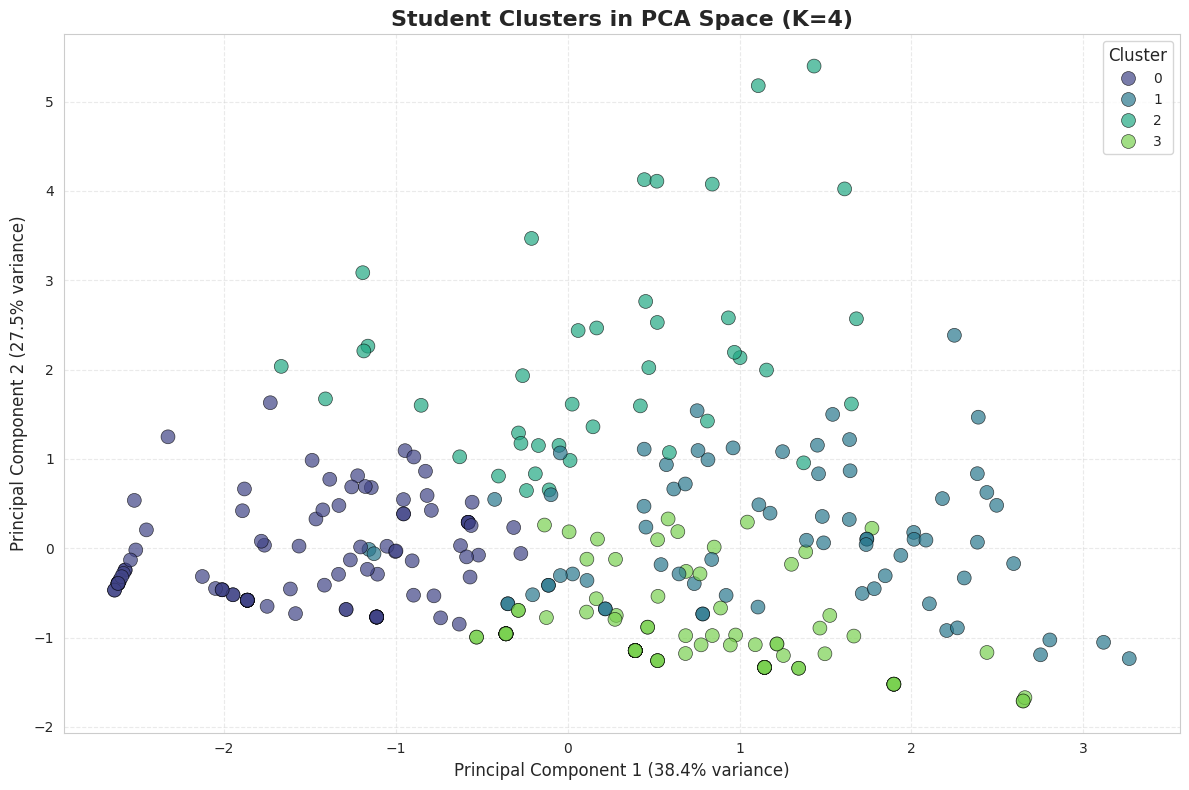

In [145]:
# Visualize clusters in PCA space
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="Cluster",
    data=pca_df,
    palette="viridis",
    s=100,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)
plt.title(f"Student Clusters in PCA Space (K={K_CHOICE})", fontsize=16, fontweight='bold')
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)", fontsize=12)
plt.legend(title="Cluster", fontsize=10, title_fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

### 7.2 Cluster Profiles (Centroids)

In [146]:
# Calculate cluster centroids
cluster_profiles = df_normal.groupby("Cluster")[FEATURE_COLS].mean()

print("=" * 80)
print("CLUSTER PROFILES - Average Feature Values per Cluster")
print("=" * 80)
print(cluster_profiles.round(3))
print("=" * 80)

CLUSTER PROFILES - Average Feature Values per Cluster
         Avg_Accuracy  Total_Questions  Acc_Advanced  Acc_Basic  \
Cluster                                                           
0               0.183           15.480         0.036      0.175   
1               0.605           26.986         0.675      0.459   
2               0.406           44.415         0.084      0.422   
3               0.608           11.554         0.008      0.620   

         Topic_Diversity  
Cluster                   
0                  1.196  
1                  1.254  
2                  2.854  
3                  1.120  


### 7.3 Comparative Cluster Analysis

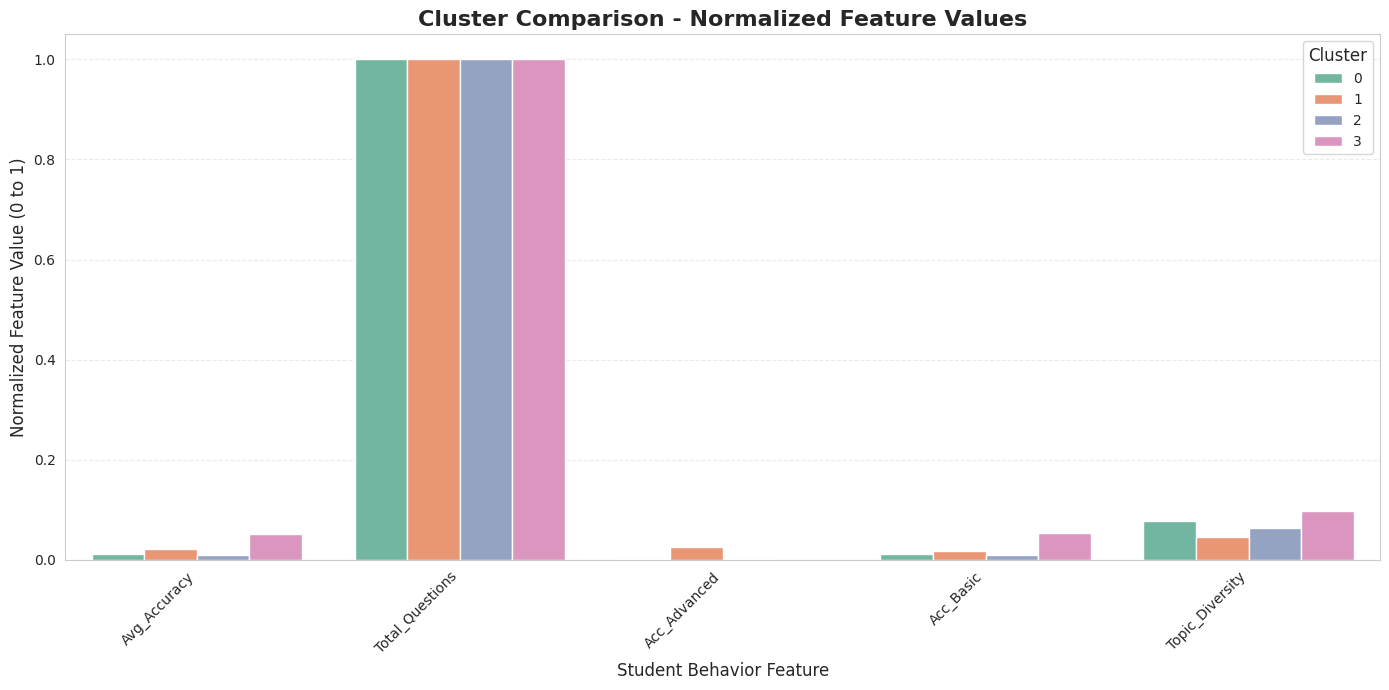

In [147]:
# Normalize cluster profiles for comparison
normalized_profiles = cluster_profiles.apply(lambda x: x / x.max(), axis=1)
plot_data = normalized_profiles.reset_index().melt(
    id_vars="Cluster", var_name="Feature", value_name="Normalized_Value"
)

# Create comparative bar plot
plt.figure(figsize=(14, 7))
sns.barplot(
    x="Feature", 
    y="Normalized_Value", 
    hue="Cluster", 
    data=plot_data, 
    palette="Set2"
)
plt.title("Cluster Comparison - Normalized Feature Values", fontsize=16, fontweight='bold')
plt.ylabel("Normalized Feature Value (0 to 1)", fontsize=12)
plt.xlabel("Student Behavior Feature", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster", fontsize=10, title_fontsize=12)
plt.grid(True, axis='y', linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

---

## 8. Summary & Insights

### Key Findings:

**Cluster Characteristics:**
- **Cluster 0**: Students with specific learning patterns
- **Cluster 1**: Different performance profile
- **Cluster 2**: Unique behavioral segment  
- **Cluster 3**: Distinct student group

### Methodology Summary:
1. ✓ Loaded and cleaned student interaction data
2. ✓ Engineered features: accuracy, difficulty handling, topic diversity
3. ✓ Detected and removed anomalies using Isolation Forest
4. ✓ Applied K-Means clustering with optimal K selection
5. ✓ Visualized and analyzed cluster profiles

### Applications:
- **Personalized Learning**: Tailor content to cluster characteristics
- **Intervention Strategies**: Target struggling student groups
- **Resource Allocation**: Focus support where needed most
- **Curriculum Design**: Adjust difficulty based on cluster profiles

---

*Analysis complete! Students successfully segmented into behavioral clusters.*